In [ ]:
# 02.03.20
# Evgenia Galytska (EG), Institute of environmental Physics (IUP), Bremen
# First results associated with Arctic amplification (AA); 
# Based on study of Marlene Kretschmer, 2016 (https://doi.org/10.1175/JCLI-D-15-0654.1)

################################DATA sources########################################################
# In this script identical to Kretschmer et al, 2016 data was applied (See Table 1 of manuscript)###
# Namely: BK-SIC   -> Nimbus-7 SMMR and DMSP SSM/I-SSMIS by National Snow and Ice Data Center    ###
#         EA-snow  -> NOAA                                                                       ###
#         AO       -> NOAA                                                                       ###
#         v flux   -> ERA-Interim daily, ESMValTool                                              ###
#         PoV      -> ERA-Interim daily, ESMValTool                                              ###
#         Sib-SLP  -> ERA-Interim daily, ESMValTool                                              ###
#         Ural-SLP -> ERA-Interim daily, ESMValTool                                              ###
# The diagnistics for calculating all actors within ESMValTool is being developed                ###
####################################################################################################

In [1]:
# Import libraries
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
import iris
import os
import xarray as xr
%matplotlib inline
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr #, GPDC, CMIknn, CMIsymb, RCOT
import iris.analysis.cartography
from datetime import datetime as dt
import time
# if detrend_on = True then the trend from all actors will be later removed
detrend_on = True

Could not import rpy package
Could not import r-package RCIT


## Read in data of all actors. 

In [2]:
DIR_ = os.path.expanduser('/work/bd0854/b380971/data_temp/as_kretch/')
PATH = os.path.join(DIR_, 'actors_kretschmer_etal_2016.nc')
ds=xr.open_dataset(PATH)
ice  = ds.BK_SIC.data
snow = ds.EA_snow.data
ao = ds.AO.data
vflux= ds.vflux.data
pv = ds.PV.data*-1   #change the sign of PV such that positive vals (negative geopotential heigh anomalies) indicate a strong PV; done identical to Kretscher et al, 2016
sib_slp = ds.Sib_SLP.data
ural_slp = ds.Ural_SLP.data
# Calculated year fraction from date information (needed for correct representation of time information on x-axis in timeseries plot)
#(https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years)
year_fraction = ds.year_fraction.data
month = ds.date.dt.month.data

## Starting analysis. 

In [3]:
#Detrending
if detrend_on:
    reg = stats.linregress(range(0,len(ice)), ice)
    ice = ice - (reg[1] + (reg[0] * range(0,len(ice))))

    reg = stats.linregress(range(0,len(snow)), snow)
    snow = snow - (reg[1] + (reg[0] * range(0,len(snow))))  

    reg = stats.linregress(range(0,len(ao)), ao)
    ao = ao - (reg[1] + (reg[0] * range(0,len(ao))))
    
    reg = stats.linregress(range(0,len(vflux)), vflux)
    vflux = vflux - (reg[1] + (reg[0] * range(0,len(vflux))))
    
    reg = stats.linregress(range(0,len(pv)), pv)
    pv = pv - (reg[1] + (reg[0] * range(0,len(pv))))
        
    reg = stats.linregress(range(0,len(sib_slp)), sib_slp)
    sib_slp = sib_slp - (reg[1] + (reg[0] * range(0,len(sib_slp))))
    
    reg = stats.linregress(range(0,len(ural_slp)), ural_slp)
    ural_slp = ural_slp - (reg[1] + (reg[0] * range(0,len(ural_slp))))

In [4]:
# Prepare numpy array for tigramite and fill it with the data loaded above
data= np.zeros((len(pv.data), 7))
data[:, 0] = pv.data
data[:, 1] = ao.data
data[:, 2] = ice.data
data[:, 3] = snow.data
data[:, 4] = vflux.data
data[:, 5] = ural_slp.data
data[:, 6] = sib_slp.data
T, N = data.shape
print("Length  N")
print(T, '   ', N)

Length  N
432     7


In [5]:
#Masking data 
data_mask = np.zeros(data.shape)
data_DJF= np.where(np.logical_and(month > 2, month < 12), 1,0) #!1 stands for data, which will be masked
for n in range (0, N):
    data_mask[:, n] = data_DJF

In [6]:
var_names = ['PV', 'AO', 'BK-SIC', 'EA-snow', 'v flux','Ural-SLP', 'Sib-SLP']
# Initialize dataframe object
dataframe = pp.DataFrame(data, datatime = year_fraction, var_names = var_names, mask = data_mask)
dataframe.mask = (dataframe.mask == True) # true vals will be masked

(<Figure size 576x432 with 7 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2af6952be210>,
       dtype=object))

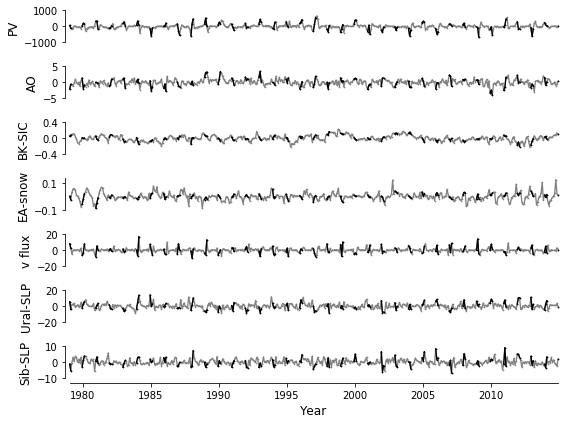

In [7]:
tp.plot_timeseries(dataframe=dataframe, 
                   figsize = (8,6),
                   time_label = 'Year',
                   data_linewidth = 1.3, 
                   skip_ticks_data_x=1,
                   skip_ticks_data_y=2,
                   label_fontsize=12,
                   use_mask=True, 
                   grey_masked_samples='data')

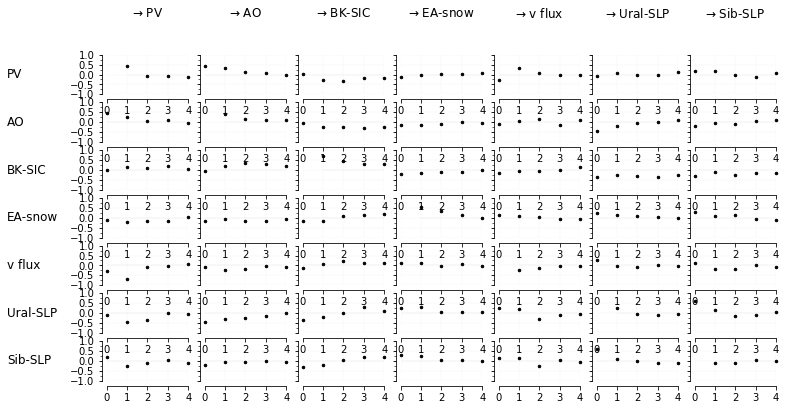

In [8]:
def run_and_plot_tau(cond_ind_test):
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)
    correlations = pcmci.get_lagged_dependencies(tau_min=0, tau_max=4)
    
    tp.plot_lagfuncs(val_matrix=correlations, 
                     setup_args={'var_names':var_names, 
                                 'x_base':1, 'y_base':0.5, 'figsize':(12,6),
                                 'minimum':-0.6, 'maximum':0.6, 
                                 'label_fontsize':12, 'plot_gridlines':True},)
run_and_plot_tau(ParCorr( significance='analytic', mask_type = 'y'))

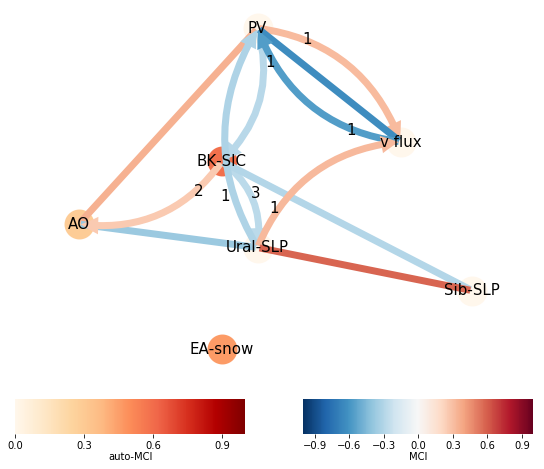

In [11]:
def run_and_plot(cond_ind_test, fig_ax):
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)
    results = pcmci.run_pcmci(tau_min=0, tau_max=3,pc_alpha=0.2) # change pc_a;ppha here if needed
    link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
            val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

    tp.plot_graph(fig_ax = fig_ax,
                  val_matrix=results['val_matrix'],
                  link_matrix=link_matrix,
                  var_names=var_names,
                  arrow_linewidth=35,   
                  vmin_edges=-1.,          
                  vmax_edges=1.,         
                  edge_ticks=.3,
                  node_ticks = 0.3,
                  node_size=30,  
                  arrowhead_size=20,   
                  curved_radius=0.3, 
                  node_label_size=15,      
                  link_label_fontsize=15,  
                  network_lower_bound=0.25,  
                  show_colorbar=True,
                  # node_pos defines the position of each actor within x-y domain range
                  node_pos = {'x': np.array([4,   1.5, 3.5,  3.5,    6,   4,  7]),
                              'y': np.array([7.7, 2.7, 4.3, -0.5,  4.8, 2.1,  1])},
    )
fig  = plt.figure(figsize=(8,8)); ax=fig.add_subplot(111)
run_and_plot(ParCorr( significance='analytic', mask_type='y'), (fig, ax))